In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import arff
import scipy as sc


# Data preparation & Exploration

In [2]:
# read the concat file from csv 

white_concat = pd.read_csv("FM_WHITE.csv")
red_concat = pd.read_csv("FM_RED.csv")



In [3]:
wine_concat = pd.read_csv("wine")

In [4]:
def get_dataset(frame):
    dffeature = frame.drop(columns=['quality_diff']) if 'quality_diff' in frame.columns else frame #Dropping the quality difference column
    
    np.random.seed(42) #Setting a consistent seed 
    featurematrix = dffeature.to_numpy() #Converting the dataframe into a numpy array 
    
    columns = len(list(dffeature.columns))
    
    X = featurematrix[:,:(columns-1)] #We split the matrix into inputs 
    y = featurematrix[:,columns-1] #Take the last column of the matrix as targets 
    return X, y


In [5]:
wX, wy = get_dataset(white_concat)
rX, ry = get_dataset(red_concat)

In [6]:
wine_concat.sample(5)

type_1  fixed acidity_1  volatile acidity_1  citric acid_1  \
6252     1.0              7.1                0.19           0.28   
4684     1.0              8.2                0.37           0.36   
1731     1.0              6.4                0.32           0.27   
4742     1.0              7.1                0.37           0.67   
4521     0.0              6.9                0.55           0.15   

      residual sugar_1  chlorides_1  free sulfur dioxide_1  \
6252               3.6        0.033                   16.0   
4684               1.0        0.034                   17.0   
1731               4.9        0.034                   18.0   
4742              10.5        0.045                   49.0   
4521               2.2        0.076                   19.0   

      total sulfur dioxide_1  density_1  pH_1  ...  residual sugar_2  \
6252                    78.0     0.9930  2.91  ...               8.0   
4684                    93.0     0.9906  3.04  ...               4.7   
1731                   122.0     0.9916  3.36  ...               4.6   
4742                   155.0     0.9975  3.16  ...               1.4   
4521                    40.0     0.9961  3.41  ...               2.8   

      chlorides_2  free sulfur dioxide_2  total sulfur dioxide_2  density_2  \
6252        0.047                   61.0                   189.0    0.99604   
4684        0.029                   21.0                    94.0    0.99100   
1731        0.028                   17.0                   114.0    0.99100   
4742        0.041                   15.0                   102.0    0.99290   
4521        0.093                   11.0                    44.0    0.99888   

      pH_2  sulphates_2  alcohol_2  quality_2  Target  
6252  3.22         0.49        9.2        5.0       1  
4684  3.29         0.62       12.3        6.0       1  
1731  3.23         0.43       13.2        6.0       0  
4742  3.26         0.53       10.4        6.0       0  
4521  3.31         0.55        9.5        6.0       0  

[5 rows x 27 columns]

In [7]:
X, y = get_dataset(wine_concat)

In [8]:
# Mostly re-use from Antony 
from fomlads.evaluate.eval_regression import train_and_test_partition
from fomlads.evaluate.eval_regression import train_and_test_filter

def dframe_train_test_input_target(dffeature,test_frac):
    """
    This function takes in the new data frame with the feature mapping already applied and converts
    this into training and testing inputs with a split given by the test_fraction. The function should
    output the training inputs and targets as well as the testing inputs and targets. 
    
    
    
    """
    #dffeature = dffeature.drop(columns=['quality_diff'])#Dropping the quality difference column
    
    np.random.seed(1) #Setting a consistent seed 
    featurematrix = dffeature.to_numpy() #Converting the dataframe into a numpy array 
    
    columns = len(list(dffeature.columns))
    
    inputs = featurematrix[:,:(columns-1)] #We split the matrix into inputs 
    targets = featurematrix[:,columns-1] #Take the last column of the matrix as targets 
    
    train_filter,test_filter=train_and_test_filter(len(dffeature),test_frac) #Applying the training and test split for the inputs and targets using our test fraction
    
    train_inputs, train_targets, test_inputs,test_targets = train_and_test_partition(inputs,targets,train_filter,test_filter) 
    
    return train_inputs,train_targets,test_inputs,test_targets #Returning our training and testing inputs and targets
    

In [9]:
W_train_inputs,W_train_targets,W_test_inputs,W_test_targets = dframe_train_test_input_target(white_concat,0.8) #W stands for white

In [10]:
R_train_inputs,R_train_targets,R_test_inputs,R_test_targets = dframe_train_test_input_target(red_concat,0.8) #R stands for Red

In [11]:

# Transform training inputs and targets to dataframe 
R_train_inputs_df = pd.DataFrame(R_train_inputs,columns = red_concat.iloc[:,:-1].columns)
R_train_targets_df = pd.DataFrame(R_train_targets,columns = red_concat.iloc[:,-1:].columns)


# Transform testing inputs to dataframe and also drop the feature 
R_test_inputs_df = pd.DataFrame(R_test_inputs,columns = red_concat.iloc[:,:-1].columns)


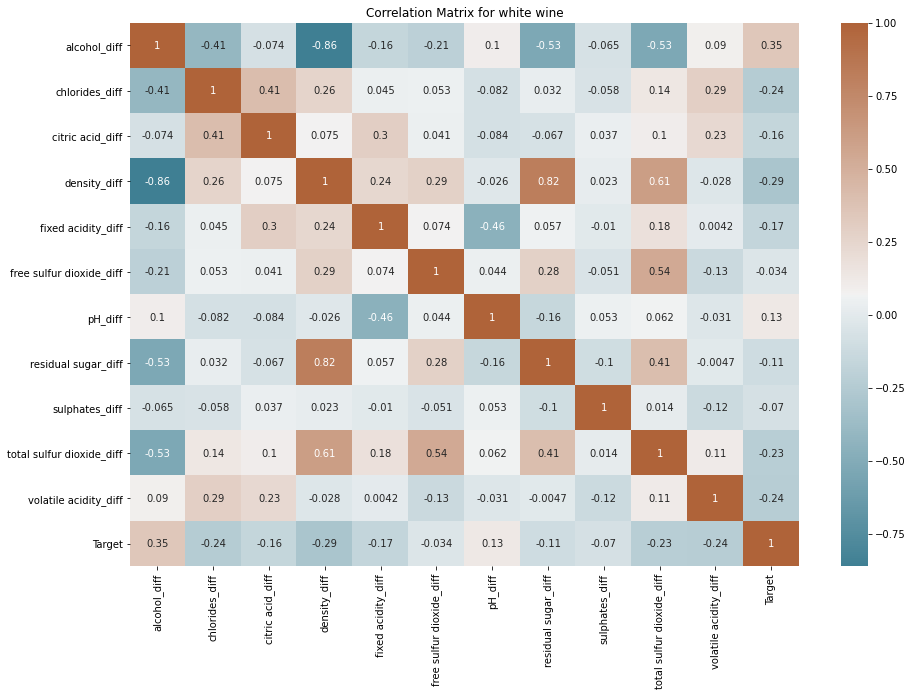

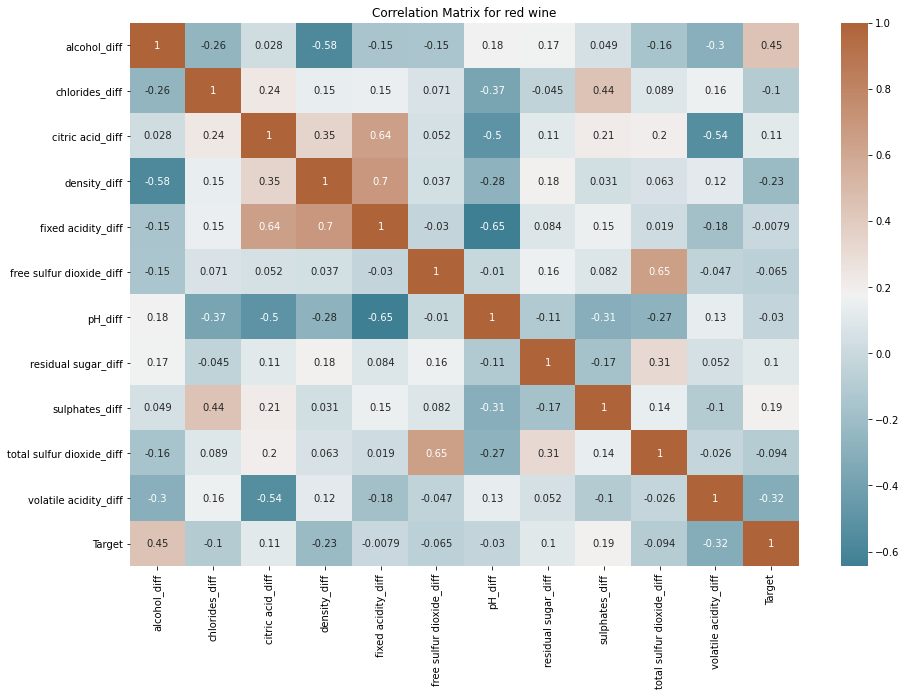

In [12]:
# Correlation bewteen matrix 
# Can discuss about inter-dependence 
# correlation here can be tested by feature importance scores in the later part 
import seaborn as sns

corr_w = white_concat.corr()
corr_r = red_concat.corr()

# Heatmap for white wine 
plt.subplots(figsize=(15,10))
ax_w = plt.axes()
sns.heatmap(corr_w, xticklabels=corr_w.columns, yticklabels=corr_w.columns, annot=True, cmap=sns.diverging_palette(220, 30, as_cmap=True),ax = ax_w)
ax_w.set_title('Correlation Matrix for white wine')

# Heatmap for red wine 
plt.subplots(figsize=(15,10))
ax_r = plt.axes()
sns.heatmap(corr_r, xticklabels=corr_r.columns, yticklabels=corr_r.columns, annot=True, cmap=sns.diverging_palette(220, 30, as_cmap=True),ax = ax_r)
ax_r.set_title('Correlation Matrix for red wine')

plt.show()




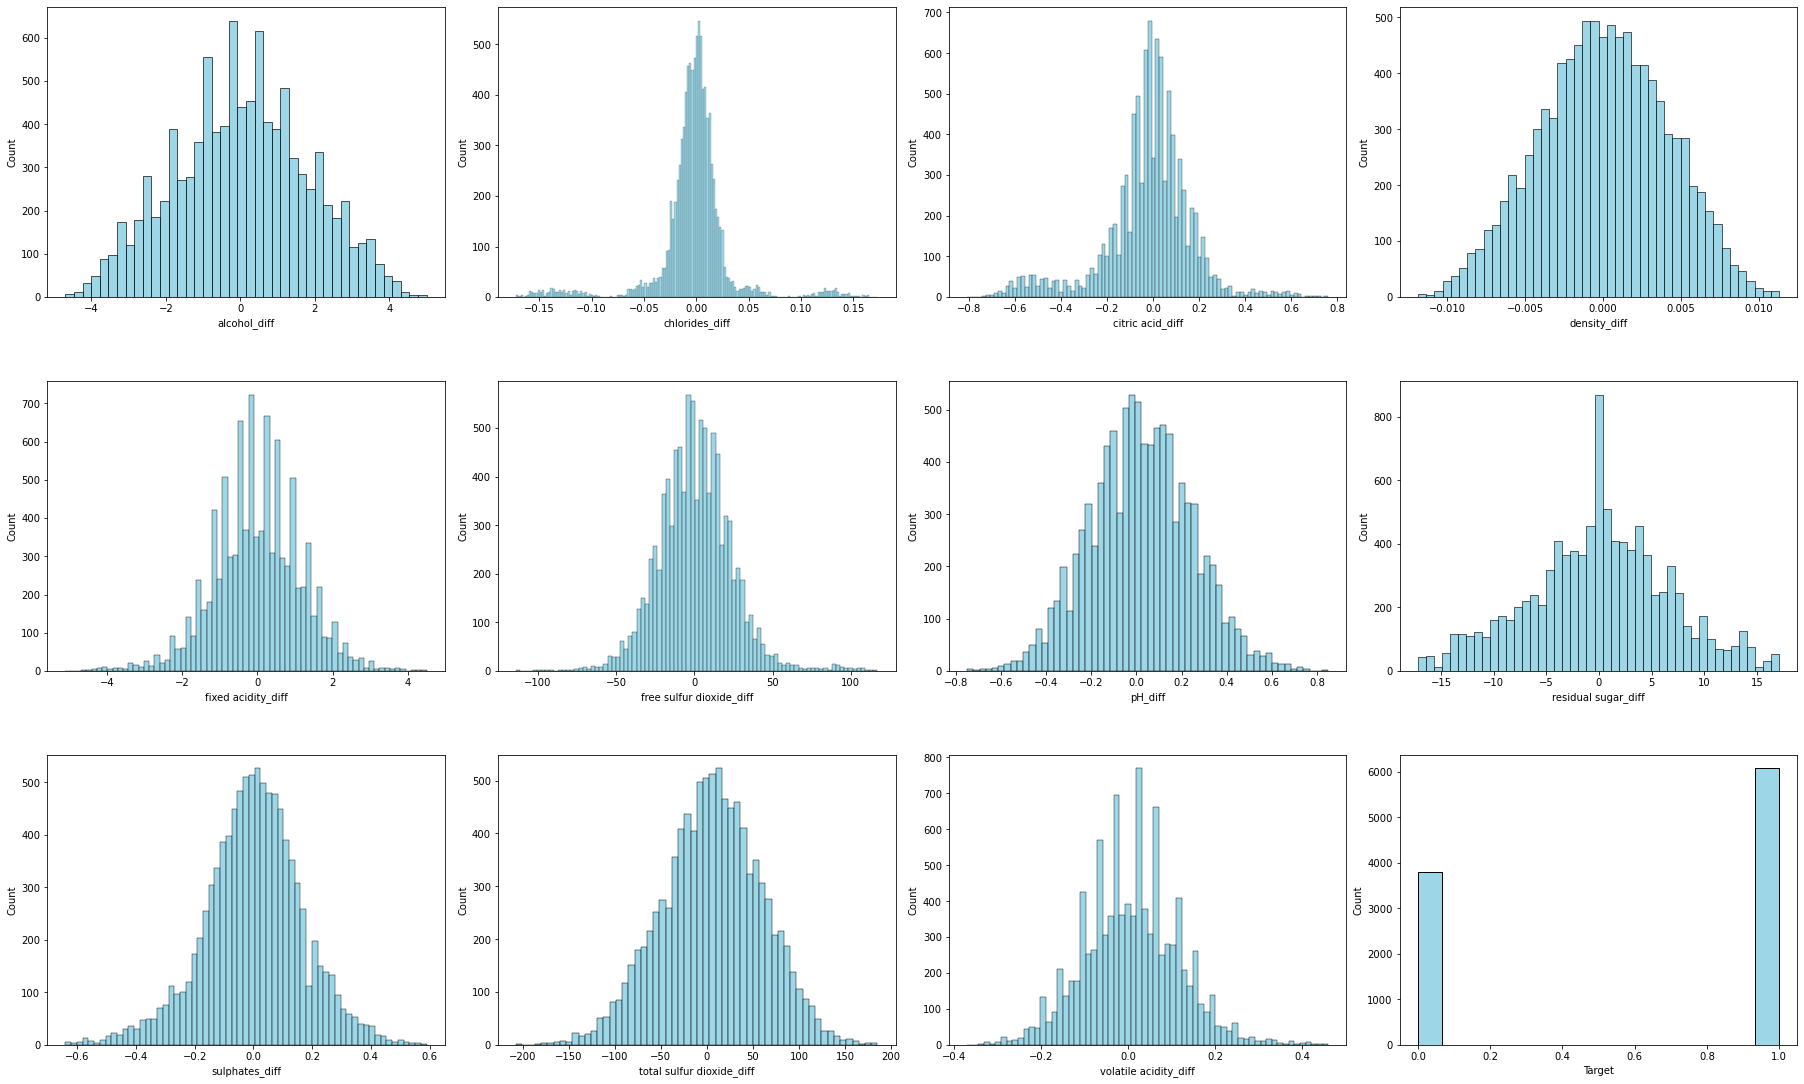

In [17]:
# Histograms checking whether features are skewed 
# possible idea for discussion: volatile acidity_dff
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(25,15))
index = 0
# White wine 
ax = ax.flatten()
for col, value in white_concat.items():
    sns.histplot(value, ax=ax[index], color="#7ccae0")
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

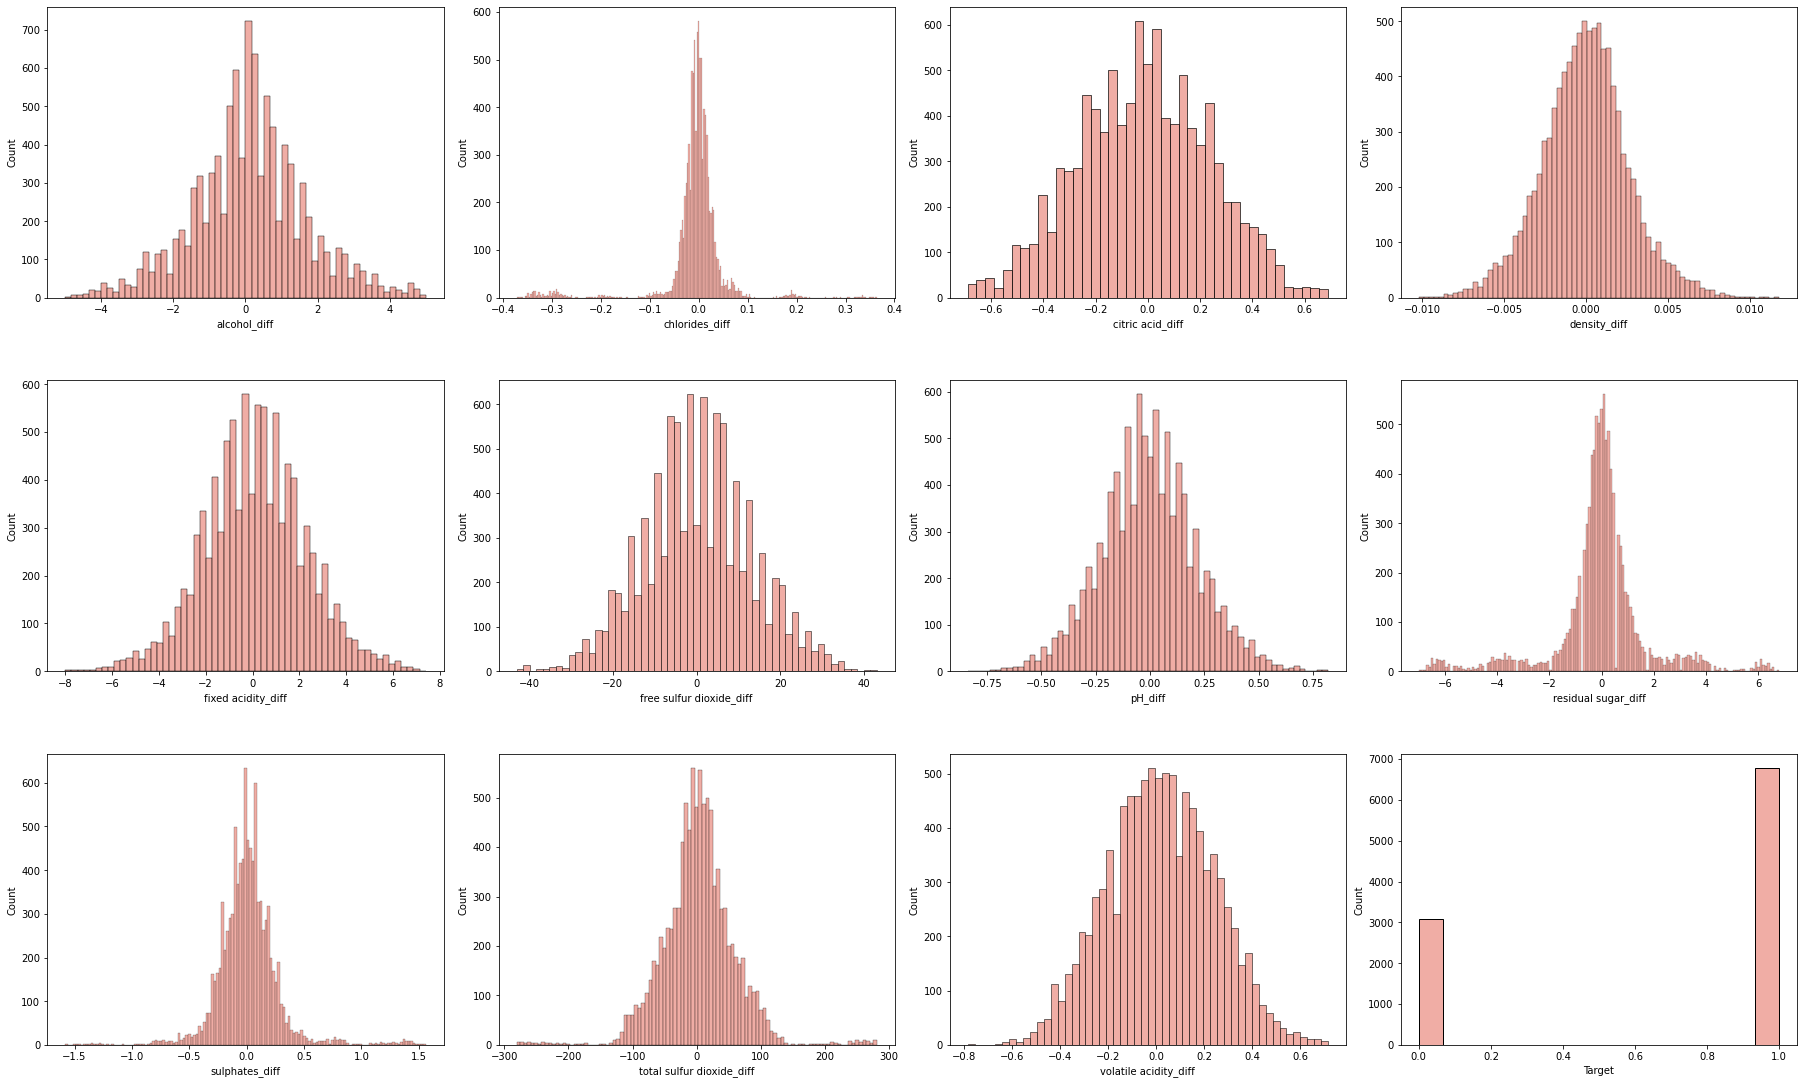

In [18]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(25,15))
index = 0
# Red wine 
ax = ax.flatten()
for col, value in red_concat.items():
    sns.histplot(value, ax=ax[index], color="#eb9287")
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

# External Model


# Random Forest

In [20]:
# Random Forest 
# import, instantiate 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# instantiate the classifier with n_estimators = 10

rfc_w = RandomForestClassifier(random_state=0)
rfc_r = RandomForestClassifier(random_state=0)

# fit the model to the training set

rfc_w.fit(W_train_inputs,W_train_targets)
rfc_r.fit(R_train_inputs,R_train_targets)

# Predict on the test set results

rfc_w_predict = rfc_w.predict(W_test_inputs)
rfc_r_predict = rfc_w.predict(R_test_inputs)

# Check accuracy score 


print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(W_test_targets, rfc_w_predict)))
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(R_test_targets, rfc_r_predict)))

Model accuracy score with 10 decision-trees : 0.7445
Model accuracy score with 10 decision-trees : 0.6754


In [21]:
# instantiate the classifier with n_estimators = 100

rfc100_w = RandomForestClassifier(n_estimators=100, random_state=0)
rfc100_r = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set

rfc100_w.fit(W_train_inputs,W_train_targets)
rfc100_r.fit(R_train_inputs,R_train_targets)

# Predict on the test set results

rfc100_w_predict = rfc100_w.predict(W_test_inputs)
rfc100_r_predict = rfc100_r.predict(R_test_inputs)


# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(W_test_targets, rfc100_w_predict)))
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(R_test_targets, rfc100_r_predict)))

Model accuracy score with 100 decision-trees : 0.7445
Model accuracy score with 100 decision-trees : 0.8084


Best parameter(n_estimators) for white wine is 93
Best parameter(n_estimators) for red wine is 61


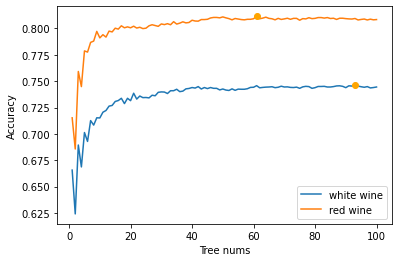

In [27]:
# find the best parameter of n_estimators
# plot the image and note the best point
def RF_ntrees(min_trees, max_trees):
    x = [x for x in range(min_trees, max_trees)]
    scores_w, scores_r = [], []
    for trees in x:
        rfc_w = RandomForestClassifier(n_estimators = trees, random_state = 0)
        rfc_r = RandomForestClassifier(n_estimators = trees, random_state = 0)
        
        rfc_w.fit(W_train_inputs,W_train_targets)
        rfc_r.fit(R_train_inputs,R_train_targets)
        
        rfc_w_predict = rfc_w.predict(W_test_inputs)
        rfc_r_predict = rfc_r.predict(R_test_inputs)
        
        scores_w.append(accuracy_score(W_test_targets, rfc_w_predict))
        scores_r.append(accuracy_score(R_test_targets, rfc_r_predict))
    
    score_max_w = max(scores_w)
    score_max_r = max(scores_r)
    
    plt.plot(x, scores_w, label = 'white wine')
    plt.plot(x, scores_r, label = 'red wine')
    plt.plot(scores_w.index(score_max_w) + 1, score_max_w, 'o', color = 'orange')
    plt.plot(scores_r.index(score_max_r) + 1, score_max_r, 'o', color = 'orange')
    plt.xlabel('Tree nums')
    plt.ylabel('Accuracy')
    plt.legend()
    print('Best parameter(n_estimators) for white wine is ' + str(min_trees + scores_w.index(score_max_w)))
    print('Best parameter(n_estimators) for red wine is ' + str(min_trees + scores_r.index(score_max_r)))
    
RF_ntrees(1, 101)



Best parameter(depth) for white wine is 17
Best parameter(depth) for red wine is 22


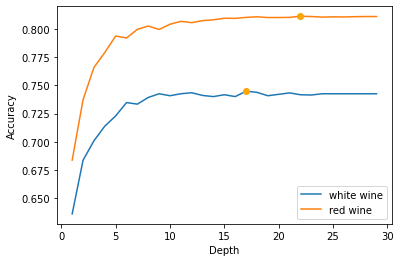

In [23]:
# find the best parameter of max_depth
# plot the image and note the best point
def RF_depth(min_depth, max_depth):
    x = [x for x in range(min_depth, max_depth)]
    scores_w, scores_r = [], []
    for depth in x:
        rfc_w = RandomForestClassifier(n_estimators = 50, max_depth = depth, random_state = 0)
        rfc_r = RandomForestClassifier(n_estimators = 50, max_depth = depth, random_state = 0)
        
        rfc_w.fit(W_train_inputs,W_train_targets)
        rfc_r.fit(R_train_inputs,R_train_targets)
        
        rfc_w_predict = rfc_w.predict(W_test_inputs)
        rfc_r_predict = rfc_r.predict(R_test_inputs)
        
        scores_w.append(accuracy_score(W_test_targets, rfc_w_predict))
        scores_r.append(accuracy_score(R_test_targets, rfc_r_predict))
    
    score_max_w = max(scores_w)
    score_max_r = max(scores_r)

    
    plt.plot(x, scores_w, label = 'white wine')
    plt.plot(x, scores_r, label = 'red wine')
    plt.plot(scores_w.index(score_max_w) + 1, score_max_w, 'o', color = 'orange')
    plt.plot(scores_r.index(score_max_r) + 1, score_max_r, 'o', color = 'orange')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    print('Best parameter(depth) for white wine is ' + str(min_depth + scores_w.index(score_max_w)))
    print('Best parameter(depth) for red wine is ' + str(min_depth + scores_r.index(score_max_r)))

    
RF_depth(1, 30)

In [20]:
# For testing 
# Random Forest Grid Search
from sklearn.model_selection import GridSearchCV
params = {'n_estimators' : range(1, 101), 'random_state' : [0]}
#params = {'max_depth': range(1, 31),}

grid_w = GridSearchCV(RandomForestClassifier(),params,refit=True,verbose=2)
grid_r = GridSearchCV(RandomForestClassifier(),params,refit=True,verbose=2)

grid_w.fit(W_train_inputs,W_train_targets)
grid_r.fit(R_train_inputs,R_train_targets)

print(grid_w.best_estimator_)
print(grid_r.best_estimator_)

ors=51, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=52, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=52, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=52, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=52, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=52, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=53, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=53, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=53, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=53, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=53, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=54, random_state=0; total time=   0.3s
[CV] END ....................n_estimators=54, random_state=0; tota

In [28]:
# feature scores for white wine 

feature_scores_w = pd.Series(rfc100_w.feature_importances_,index = white_concat.iloc[:,:-1].columns).sort_values(ascending=False)
feature_scores_w

density_diff                 0.123361
alcohol_diff                 0.120621
volatile acidity_diff        0.110872
total sulfur dioxide_diff    0.088507
free sulfur dioxide_diff     0.087289
residual sugar_diff          0.085207
chlorides_diff               0.079996
citric acid_diff             0.079707
pH_diff                      0.079444
sulphates_diff               0.078434
fixed acidity_diff           0.066562
dtype: float64

In [29]:
# feature scores for red wine 
feature_scores_r = pd.Series(rfc100_r.feature_importances_,index = red_concat.iloc[:,:-1].columns).sort_values(ascending=False)
feature_scores_r 

alcohol_diff                 0.203683
volatile acidity_diff        0.118481
sulphates_diff               0.102960
chlorides_diff               0.085109
density_diff                 0.082984
total sulfur dioxide_diff    0.079686
residual sugar_diff          0.069091
citric acid_diff             0.066941
free sulfur dioxide_diff     0.066244
pH_diff                      0.063212
fixed acidity_diff           0.061608
dtype: float64

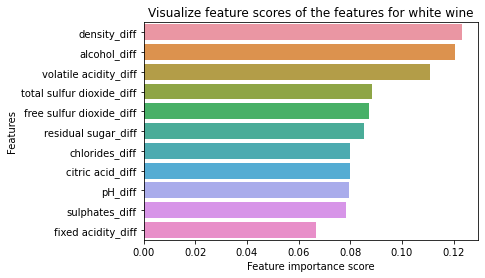

In [30]:
# Creating a seaborn bar plot for white wine 
import seaborn as sns
f, ax = plt.subplots()
ax = sns.barplot(x=feature_scores_w, y=feature_scores_w.index)
ax.set_title("Visualize feature scores of the features for white wine")
ax.set_yticklabels(feature_scores_w.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

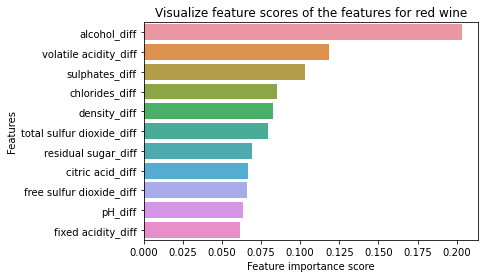

In [31]:
# Creating a seaborn bar plot for red wine 
import seaborn as sns
f, ax = plt.subplots()
ax = sns.barplot(x=feature_scores_r, y=feature_scores_r.index)
ax.set_title("Visualize feature scores of the features for red wine")
ax.set_yticklabels(feature_scores_r.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [32]:
white_concat.head()

alcohol_diff  chlorides_diff  citric acid_diff  density_diff  \
0          -2.2           0.003              0.02       0.00816   
1          -0.4          -0.007              0.01       0.00226   
2           1.8          -0.010             -0.01      -0.00590   
3          -2.4           0.025              0.07       0.00716   
4          -0.2           0.022              0.05      -0.00100   

   fixed acidity_diff  free sulfur dioxide_diff  pH_diff  residual sugar_diff  \
0                 1.6                       4.0    -0.26                 13.5   
1                 0.5                     -27.0    -0.09                  4.7   
2                -1.1                     -31.0     0.17                 -8.8   
3                 1.6                      18.0    -0.35                 12.2   
4                 0.0                      14.0    -0.09                 -1.3   

   sulphates_diff  total sulfur dioxide_diff  volatile acidity_diff  Target  
0            0.02                       92.0                  -0.07       0  
1           -0.07                       -4.0                   0.09       1  
2           -0.09                      -96.0                   0.16       1  
3            0.00                       77.0                  -0.01       0  
4           -0.02                      -15.0                   0.06       1

In [33]:
# Test: change array to dataframe to drop the less important variable 

# DROP the feature pH_dff
R_train_inputs_df_drop = R_train_inputs_df.drop(['pH_diff'],axis = 1)
R_test_inputs_df_drop = R_test_inputs_df.drop(['pH_diff'],axis = 1)

# instantiate the classifier with n_estimators = 100

rfc100_r_drop = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model to the training set

rfc100_r_drop.fit(R_train_inputs_df_drop,R_train_targets_df)


# Predict on the test set results

rfc100_r_drop_predict = rfc100_r_drop.predict(R_test_inputs_df_drop)



# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(R_test_targets, rfc100_r_drop_predict)))




<ipython-input-33-61d50e382a18>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc100_r_drop.fit(R_train_inputs_df_drop,R_train_targets_df)


Model accuracy score with 100 decision-trees : 0.8079


In [34]:
# Confusion Matrix Function 

def confusion_matrix(true_classes,predicted_classes):

    classes = set(true_classes)
    confusionmatrix  = pd.DataFrame(
        np.zeros((2,2),dtype=int),
        index=classes,
        columns=classes)

    for true_label, prediction in zip(true_classes ,predicted_classes):
        confusionmatrix.loc[true_label, prediction] += 1

    return confusionmatrix.values 

In [35]:
print('Confusion matrix for white wine \n\n' + str(confusion_matrix(W_test_targets,rfc100_w_predict)))
print('\nConfusion matrix for red wine \n\n' + str(confusion_matrix(R_test_targets,rfc100_r_predict)))


Confusion matrix for white wine 

[[1843 1211]
 [ 818 4068]]

Confusion matrix for red wine 

[[1474 1037]
 [ 484 4945]]


In [36]:
# Testing: confusion matrix 
from sklearn.metrics import confusion_matrix

cm_w = confusion_matrix(W_test_targets, rfc100_w_predict)
cm_r = confusion_matrix(R_test_targets, rfc100_r_predict)

print('Confusion matrix for white wine \n\n', cm_w)
print('\n\nConfusion matrix for red wine \n\n', cm_r)

Confusion matrix for white wine 

 [[1843 1211]
 [ 818 4068]]


Confusion matrix for red wine 

 [[1474 1037]
 [ 484 4945]]


In [37]:
# Plot Confusion Matrix Function 
def plot_cm(true_classes,predicted_classes):
    cm_matrix_svc_w = pd.DataFrame(data=confusion_matrix(true_classes,predicted_classes), columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix_svc_w, annot=True, fmt='d',cmap = "Blues")

Confusion matrix Visualization for white wine


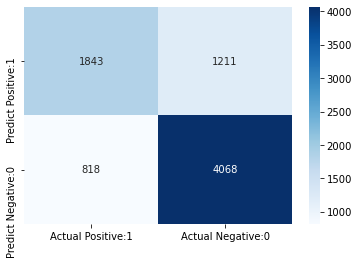

In [38]:
# Visualize confusion matrix with heatmap 
print('Confusion matrix Visualization for white wine')
plot_cm(W_test_targets,rfc100_w_predict)


Confusion matrix Visualization for red wine


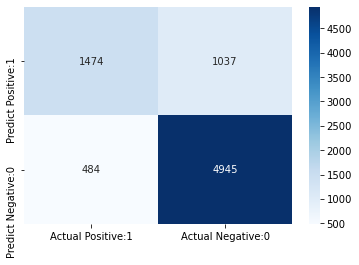

In [39]:
print('Confusion matrix Visualization for red wine')
plot_cm(R_test_targets,rfc100_r_predict)

In [40]:
# Classification Report 
from sklearn.metrics import classification_report

print("Classification Report for white wine\n\n" + classification_report(W_test_targets, rfc100_w_predict))
print("Classification Report for red wine\n\n" + classification_report(R_test_targets, rfc100_r_predict))



Classification Report for white wine

              precision    recall  f1-score   support

         0.0       0.69      0.60      0.64      3054
         1.0       0.77      0.83      0.80      4886

    accuracy                           0.74      7940
   macro avg       0.73      0.72      0.72      7940
weighted avg       0.74      0.74      0.74      7940

Classification Report for red wine

              precision    recall  f1-score   support

         0.0       0.75      0.59      0.66      2511
         1.0       0.83      0.91      0.87      5429

    accuracy                           0.81      7940
   macro avg       0.79      0.75      0.76      7940
weighted avg       0.80      0.81      0.80      7940



# Support Vector Machine 

In [41]:
# Support Vector Machine 

# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc_w=SVC() 
svc_r=SVC()


# fit classifier to training set
svc_w.fit(W_train_inputs,W_train_targets)
svc_r.fit(R_train_inputs,R_train_targets)

# make predictions on test set
svc_w_predict=svc_w.predict(W_test_inputs)
svc_r_predict=svc_r.predict(R_test_inputs)

print('Model accuracy score with default hyperparameters for white wine: {0:0.4f}'. format(accuracy_score(W_test_targets, svc_w_predict)))
print('Model accuracy score with default hyperparameters for red wine: {0:0.4f}'. format(accuracy_score(R_test_targets, svc_r_predict)))

Model accuracy score with default hyperparameters for white wine: 0.6631
Model accuracy score with default hyperparameters for red wine: 0.6890


In [47]:
# Instantite classificier with C = 100 

svc_w_100=SVC(C=100.0) 
svc_r_100=SVC(C=100.0) 


# fit classifier to training set
svc_w_100.fit(W_train_inputs,W_train_targets)
svc_r_100.fit(R_train_inputs,R_train_targets)

# make predictions on test set
svc_w_100_predict=svc_w_100.predict(W_test_inputs)
svc_r_100_predict=svc_w_100.predict(R_test_inputs)

print('Model accuracy score with C=100 for white wine: {0:0.4f}'. format(accuracy_score(W_test_targets, svc_w_100_predict)))
print('Model accuracy score with C=100 for red wine: {0:0.4f}'. format(accuracy_score(R_test_targets, svc_r_100_predict)))


Model accuracy score with C=100 for white wine: 0.7029
Model accuracy score with C=100 for red wine: 0.6899


Best parameter(C) for white wine is 210
Best parameter(C) for red wine is 480


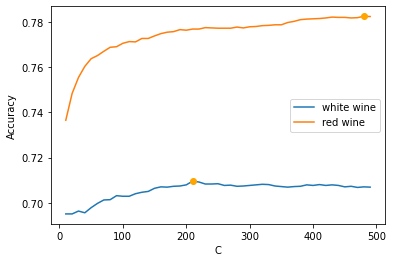

In [63]:
# find the best parameter of C
# plot the image and note the best point
def SVM_C(min_C, max_C):
    x = [x for x in range(min_C, max_C, 10)]
    scores_w, scores_r = [], []
    for C in x:
        svc_w = SVC(C = C)
        svc_r = SVC(C = C)
        
        svc_w.fit(W_train_inputs, W_train_targets)
        svc_r.fit(R_train_inputs, R_train_targets)
        
        svc_w_predict = svc_w.predict(W_test_inputs)
        svc_r_predict = svc_r.predict(R_test_inputs)
        
        scores_w.append(accuracy_score(W_test_targets, svc_w_predict))
        scores_r.append(accuracy_score(R_test_targets, svc_r_predict))
    
    score_max_w = max(scores_w)
    score_max_r = max(scores_r)
    
    plt.plot(x, scores_w, label = 'white wine')
    plt.plot(x, scores_r, label = 'red wine')
    plt.plot((scores_w.index(score_max_w)+1) * 10, score_max_w, 'o', color = 'orange')
    plt.plot((scores_r.index(score_max_r)+1) * 10, score_max_r, 'o', color = 'orange')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.legend()
    print('Best parameter(C) for white wine is ' + str(min_C + scores_w.index(score_max_w) * 10))
    print('Best parameter(C) for red wine is ' + str(min_C + scores_r.index(score_max_r) * 10))
    

SVM_C(10, 500)

Confusion matrix Visualization for white wine


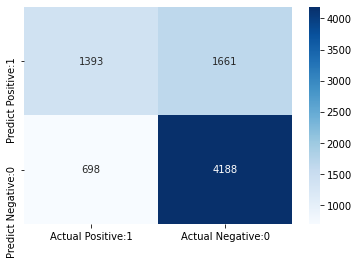

In [36]:
# Visualize confusion matrix with heatmap for SVC (white wine)

print('Confusion matrix Visualization for white wine')
plot_cm(W_test_targets,svc_w_100_predict)


Confusion matrix Visualization for red wine


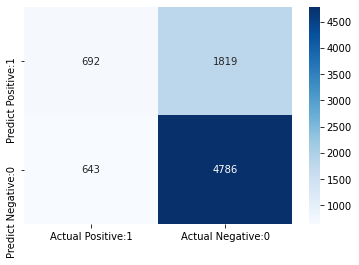

In [37]:
# Visualize confusion matrix with heatmap for SVC (red wine)
print('Confusion matrix Visualization for red wine')
plot_cm(R_test_targets,svc_r_100_predict)


In [38]:
print(confusion_matrix(W_test_targets, svc_w_100_predict)[1,1])

4188


In [39]:
# Function for classification Report 
def classificationreport(true_classes,predicted_classes):
    cm = confusion_matrix(true_classes,predicted_classes)
    recall = cm[0,0]/(cm[0,0]+cm[0,1])
    precision = cm[0,0]/(cm[0,0]+cm[1,0])
    f1_score = 2*precision*recall / (precision+recall)
    acc = np.sum(np.equal(true_classes, predicted_classes)) / len(true_classes)
   
    print('Precison is: {0:0.4f}'. format(precision))
    print('Recall is: {0:0.4f}'. format(recall))
    print('F1_Score is: {0:0.4f}'. format(f1_score))
    print('Accuracy is: {0:0.4f}'. format(acc))

print("Classification Report for white wine\n\n")
classificationreport(W_test_targets, svc_w_100_predict)

print("\nClassification Report for red wine\n\n")
classificationreport(R_test_targets, svc_r_100_predict)

Classification Report for white wine


Precison is: 0.6662
Recall is: 0.4561
F1_Score is: 0.5415
Accuracy is: 0.7029

Classification Report for red wine


Precison is: 0.5184
Recall is: 0.2756
F1_Score is: 0.3599
Accuracy is: 0.6899


In [40]:
# Testing 
# Classiciation Report Funcation 
print("Classification Report for white wine\n\n" + classification_report(W_test_targets, svc_w_100_predict))
print("Classification Report for red wine\n\n" + classification_report(R_test_targets, svc_r_100_predict))


Classification Report for white wine

              precision    recall  f1-score   support

         0.0       0.67      0.46      0.54      3054
         1.0       0.72      0.86      0.78      4886

    accuracy                           0.70      7940
   macro avg       0.69      0.66      0.66      7940
weighted avg       0.70      0.70      0.69      7940

Classification Report for red wine

              precision    recall  f1-score   support

         0.0       0.52      0.28      0.36      2511
         1.0       0.72      0.88      0.80      5429

    accuracy                           0.69      7940
   macro avg       0.62      0.58      0.58      7940
weighted avg       0.66      0.69      0.66      7940



In [41]:
# For testing 
# SVM Grid Search
#params = {'C' : [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
params = {'C' : [0.1, 1, 10, 100],'gamma': [1,0.1,0.01,0.001],}
#params = {'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),params,refit=True,verbose=2)

grid.fit(W_train_inputs,W_train_targets)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.4s
[CV] END .....................................C=0.1, gamma=1; total time=   0.2s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.2s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

In [42]:
print(grid.best_estimator_)


SVC(C=100, gamma=0.001)


In [43]:
grid.fit(R_train_inputs,R_train_targets)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.8s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END .....................................C=0.1, gamma=1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.2s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

In [44]:
print(grid.best_estimator_)

SVC(C=100, gamma=0.001)


# Quick Methods Comparison

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso


In [34]:
# Function for cross validation 
def cross_validation(model, X, y, cv):
    Xfolds = np.split(X, cv)
    yfolds = np.split(y, cv)
    cross_vals = []
    for fold in range(cv):
        y_test = yfolds[fold]
        X_test = Xfolds[fold]
        
        X_train_temp = Xfolds[:fold]
        X_train_temp.extend(Xfolds[fold+1:])
        X_train = np.vstack(X_train_temp)
        y_train_temp = yfolds[:fold]
        y_train_temp.extend(yfolds[fold+1:])
        y_train = np.hstack(y_train_temp)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        val_acc = accuracy_score(y_test, y_predict)
        cross_vals.append(val_acc)
    return cross_vals

In [35]:
#from sklearn.model_selection import cross_val_score

models = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), SVC(),]
def evaluate_models(method, X, y, output=False):
    
    model = method
    
    scores = cross_validation(model, X, y, cv=5)
    avg_cv = np.mean(scores)
    var_cv = np.std(scores)
    if output:
        print(model)
        print("avg cv score is:", avg_cv, "std is:", var_cv)
    return avg_cv, var_cv

for mod in models:
    evaluate_models(mod, X, y, output = True)

KNeighborsClassifier()
avg cv score is: 0.7376999999999999 std is: 0.03636426817632937
GaussianNB()
avg cv score is: 0.8463 std is: 0.016554757624320605
DecisionTreeClassifier()
avg cv score is: 0.9998000000000001 std is: 0.00024494897427829084
SVC()
avg cv score is: 0.6998 std is: 0.0848985276668565


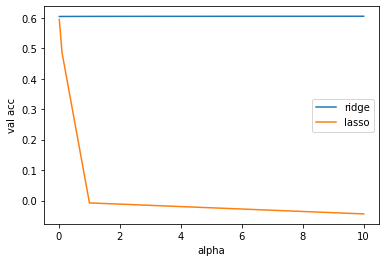

In [47]:
alphas = [0.01, 0.1, 1, 10]
ridge_vals = []
lasso_vals = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    val_acc, _= evaluate_models(model, X, y)
    ridge_vals.append(val_acc)

    model = Lasso(alpha=alpha)
    val_acc, _= evaluate_models(model, X, y)
    lasso_vals.append(val_acc)
plt.plot(alphas, ridge_vals, label = 'ridge')
plt.plot(alphas, lasso_vals, label = "lasso")
plt.xlabel("alpha")
plt.ylabel("val acc")
plt.legend()
plt.show()
    

# Cross Validation 

In [48]:
# Function for cross validation 
def cross_validation(model, X, y, cv):
    Xfolds = np.split(X, cv)
    yfolds = np.split(y, cv)
    cross_vals = []
    for fold in range(cv):
        y_test = yfolds[fold]
        X_test = Xfolds[fold]
        
        X_train_temp = Xfolds[:fold]
        X_train_temp.extend(Xfolds[fold+1:])
        X_train = np.vstack(X_train_temp)
        y_train_temp = yfolds[:fold]
        y_train_temp.extend(yfolds[fold+1:])
        y_train = np.hstack(y_train_temp)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        val_acc = accuracy_score(y_test, y_predict)
        cross_vals.append(val_acc)
    return cross_vals

In [49]:
# use of it 
model = RandomForestClassifier(n_estimators = 36, random_state = 0)
cross_validation(model, X, y, cv=5)

[0.9975, 0.9705, 0.982, 0.991, 0.9975]